## Company X Time Series Challenge:
Congratulations on reaching this step in the interview process.
In this challenge you have been provided with a time series dataset (timeseries.csv). In the CSV you will find three time series.

### The challenge
Your assignment is to analyse the provided time series and provide forecasts for each of them. The forecast should span at least a month. 

### The solution
The solution should be a CSV containing your forecasts. Alongside your solution please provide either a script (e.g. Python, R) with comments or preferably in a Jupyter Notebook that helped you generate the solution. Please describe and explain the steps which you make. 
Additionally we will ask you to prepare a two-slide presentation in which you present your solution and the results.

### Import required libraries and read data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 14})

In [2]:
df = pd.read_csv("../data/timeseries.csv", names=['datetime','varA','varB','varC'])

### Process data and do EDA

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [4]:
df.describe()

,varA,varB,varC
count,56161.000000,28081.000000,56161.000000
mean,11.742989,2269.576264,-11371.310714
std,32.300104,2715.896360,13487.276642
min,0.000000,-406.744464,-44226.000000
25%,0.000000,21.050881,-22635.000000
50%,0.000000,1038.708251,-6220.000000
75%,0.000000,4245.003171,-1891.000000
max,136.000000,11449.526324,10000.000000


From the plot below we see that the variables have different patterns. The first variable (varA) is data ata 5 minute frequency but only for the last few days of the month, varB is data recorded every 10 minutes and seems to start as of March 2019 (before it's close to 0) and varC is a 5 minute recorded variable that has a sequencial pattern trending down but with some increase periods in the past.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11bb57950>,
      dtype=object)

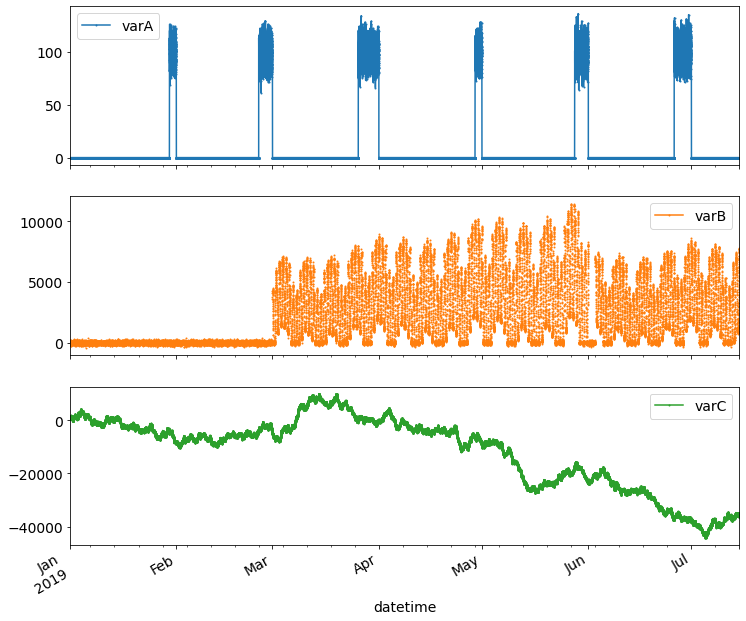

In [5]:
pd.plotting.register_matplotlib_converters()
df.plot(kind='line', subplots=True, figsize=(12,11), style='-o', markersize=1)

The following plots represent the data resampled to the hour and to the day. Resampling the data we see that varA seem to be stable and doesn't show seasonal hourly or daily patterns. The second variable, varB, has a strong seasonal pattern. And varC doesn't seem to have a strong seasonal pattern either.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10fa1a050>,
      dtype=object)

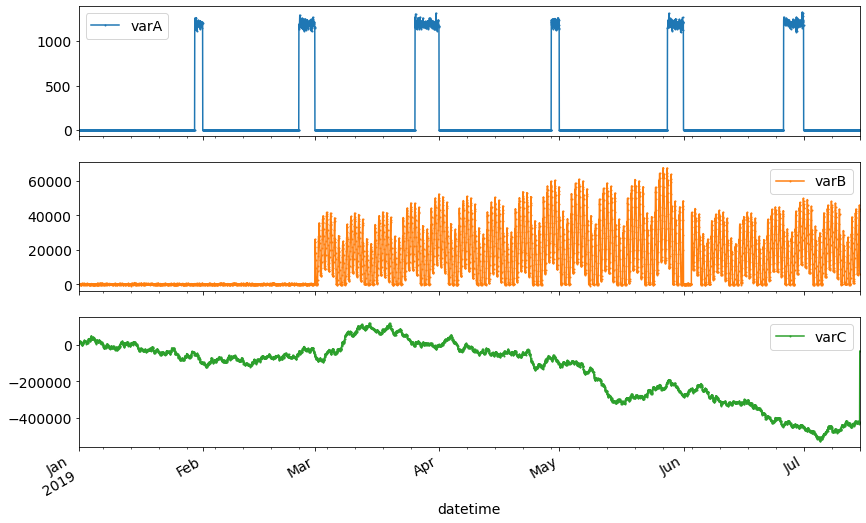

In [6]:
pd.plotting.register_matplotlib_converters()
df.resample('H').sum().plot(kind='line', subplots=True, figsize=(14,9), style='-o', markersize=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c741650>,
      dtype=object)

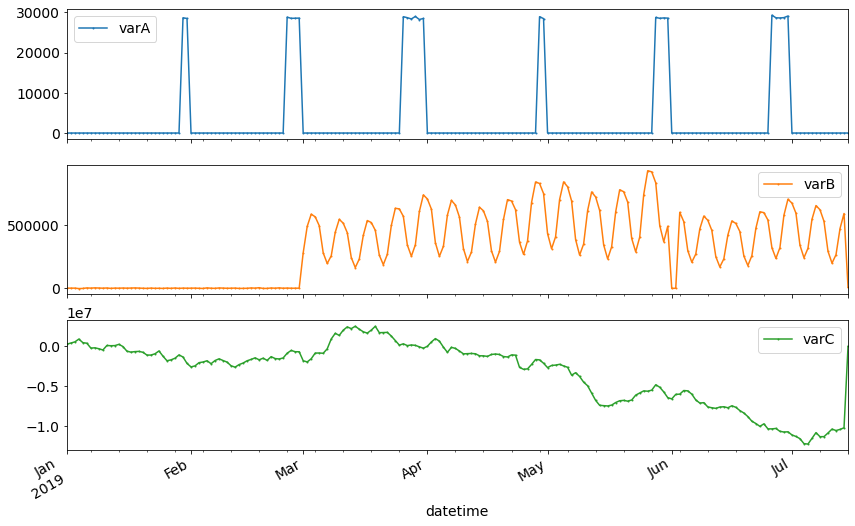

In [7]:
pd.plotting.register_matplotlib_converters()
df.resample('D').sum().plot(kind='line', subplots=True, figsize=(14,9), style='-o', markersize=1)

The three variables are going to be forecasted independently and using different models:
* varA: due to the gaps in the series and the fact that data is only recorded at the end of the month I'm going to use a Prophet time series model
* varB: due to a strong seasonal pattern I'm going to also use a Prophet time series model
* varC: in this case looks interesting to include a memory component so the predictions doesn't depend only on the trend. Since there is no strong seasonalty either, I'm going to set up a simple LSTM model.

#### The forecast end date is going to be 30 days from the last date of the provided dataset

In [8]:
final_datetime = (df.index.max() + timedelta(days=30))
print('End of forecast date:', final_datetime)

End of forecast date: 2019-08-14 00:00:00


## Forecasting varA fitting a Prophet model

In [9]:
# clean data
dfA = df[['varA']].replace(0, np.nan).dropna()

In [10]:
# it is assumed that this variable has data from the 25th day of the month until the end of the month
dfA.index.day.min()

25

#### Defining a function to train a Prophet model with optimized parameters

The function below will be used to get the optimal parameters from a Prophet model using Grid Search and selecting the model with lowest mean absolut percentage error.

In [11]:
def prophet_model(data, horizon_days):
    
    from fbprophet import Prophet
    from sklearn.model_selection import ParameterGrid
    from fbprophet.diagnostics import cross_validation
    
    # define error function
    def mape(true, pred):
        return np.mean(np.abs((true - pred) / true)) * 100
    
    # transform data into prophet format
    idx_name = data.index.name
    data.index.rename('ds', inplace=True)
    data.rename({data.columns[0]: 'y'}, axis=1, inplace=True)
    
    # define grid to do grid search
    params_grid = {'changepoint_prior_scale': [0.05, 0.1, 0.5],
                   'seasonality_prior_scale': [5, 10, 30]}
    grid = ParameterGrid(params_grid)

    # fit Prophet and evaluate score
    list_score = []
    for p in grid:
        m=Prophet(**p)
        m.fit(data.reset_index())
        cv = cross_validation(m, horizon=horizon_days)
        p['mape'] = mape(cv.y, cv.yhat)
        list_score.append(p)
    
    # get the parameters from the model that performed better
    best_model = min(list_score, key=lambda x:x['mape'])
    print('MAPE: ', best_model['mape'])
    best_model.pop('mape', None)
    
    # fit model with best parameters
    m = Prophet(**best_model)
    m.fit(data.reset_index())
    
    return m

In [12]:
model_varA = prophet_model(dfA, horizon_days='30 days')

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-05-01 23:55:00 and 2019-05-31 23:55:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-05-01 23:55:00 and 2019-05-31 23:55:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-05-01 23:55:00 and 2019-05-31 23:55:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-05-01 23:55:00 and 2019-05-31 23:55:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 3 fo

MAPE:  8.112463390633454


#### Defining a function to plot the results

In [13]:
def plot_prophet(model, forecast):
    
    from fbprophet.plot import add_changepoints_to_plot    
    
    fig1 = model.plot(forecast)
    add_changepoints_to_plot(fig1.gca(), model, fcst)
    plt.show()
    fig2 = model.plot_components(forecast)
    plt.show()

In [14]:
def plot_forecast(data, forecast, title=None, m=None):
        
    plt.figure(figsize=(14,7))
    plt.plot(data, label='actuals', marker=m)
    plt.plot(forecast, label='prediction', marker=m)
    plt.ylabel('value')
    plt.xlabel('date')
    plt.title(title)
    plt.legend()
    plt.show()

#### Create forecast dataset,  predict using the optimized model and save results

The code below uses the optimized Prophet model to forecast given a horizon time frame and vizualises the results. As expected, the daily and weekly seasonality patterns don't have a lot od influence on the series. The model captured some change points along the trend and is predicting a faster growth from June 2019.

============= Prophet summary plots (model, trend and seasonality) =============


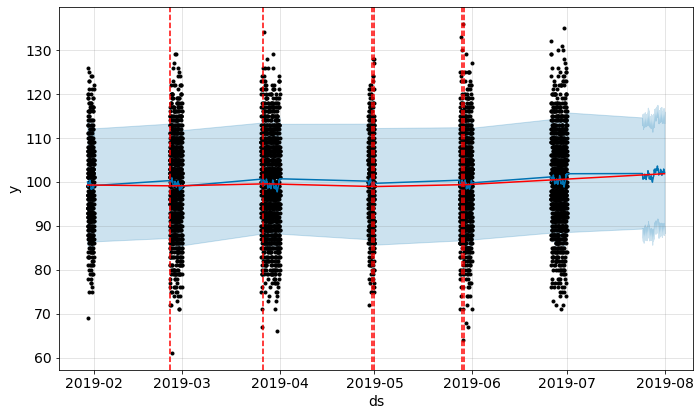

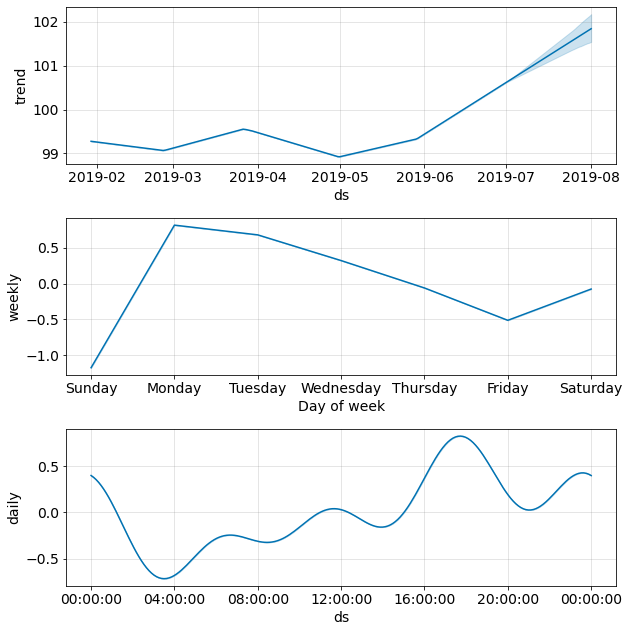

============= Forecast results for varA =============


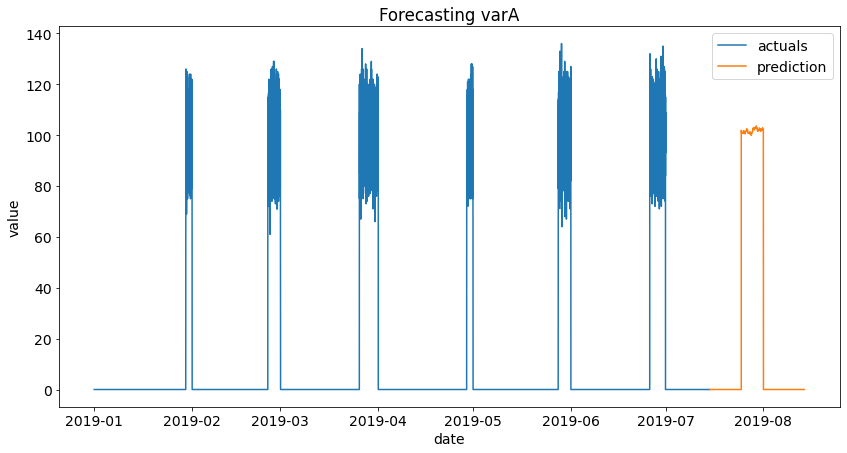

In [15]:
# create dataframe from 25th of the month
horizon_days = (final_datetime - dfA.index.max()).days
f = '5T'
horizon_period = horizon_days * 24 * 12 # days to 5 minute pediods
future = model_varA.make_future_dataframe(periods=horizon_period, freq=f)
future = future[future['ds'].dt.day >= 25] # imposing future dataframe from day 25th of the month

# predict
fcst = model_varA.predict(future)

# plot results
print('============= Prophet summary plots (model, trend and seasonality) =============')
plot_prophet(model_varA, fcst)

# save forecast results
varA_pred = fcst[fcst['ds'] > dfA.index.max()][['ds','yhat']]\
    .rename(columns={'yhat': 'varA'})\
    .set_index('ds')

# create datetime range
fcst_series = pd.date_range(start = df.index.max() + timedelta(minutes=5), end=final_datetime, freq=f)

# create results dataframe
forecast_varA = pd.DataFrame(fcst_series, columns=['datetime']).set_index('datetime')
forecast_varA['varA'] = varA_pred
forecast_varA = forecast_varA.replace(np.nan, 0)

# plot forecast
print('============= Forecast results for varA =============')
plot_forecast(df[['varA']], forecast_varA, title='Forecasting varA', m=None)

##  Forecasting varB fitting a Prophet model

In [16]:
# clean data
dfB = df[['varB']].replace(0, np.nan).dropna()

In [17]:
# get frequency
f = pd.infer_freq(dfB.index)
print('Frequency of the data:', f)

Frequency of the data: 10T


Data in varB seems to start being stable as of March 2019. Without further context on the data, I'm assuming that data before this date is not useful to predict into the future, so I'm removing it.

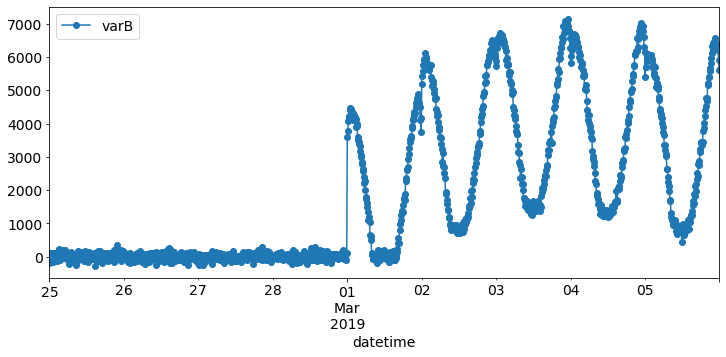

In [18]:
dfB.loc['2019-02-25':'2019-03-05'].plot(figsize=(12,5), style='-o')

In [19]:
# Not coonsidering data before March since looks useless to predict into the future
dfB = dfB.loc['2019-03':]

In [20]:
model_varB = prophet_model(dfB, horizon_days='30 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-31 00:00:00 and 2019-06-15 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-31 00:00:00 and 2019-06-15 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-31 00:00:00 and 2019-06-15 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-31 00:00:00 and 2019-06-15 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-05-31 00:00:00 and 2019-

MAPE:  4720.700297654794


#### Create forecast dataset,  predict using the optimized model and save results

The code below uses the optimized Prophet model to forecast given a horizon time frame and vizualises the results. The model detects a strong daily seasonality pattern (around 12pm data is much lower than at 12am) as well as weekly (Sunday, Monday and Tuesday have greater values than the other days of the week). In terms of trend, the model captured well the change points around end of March 2019.

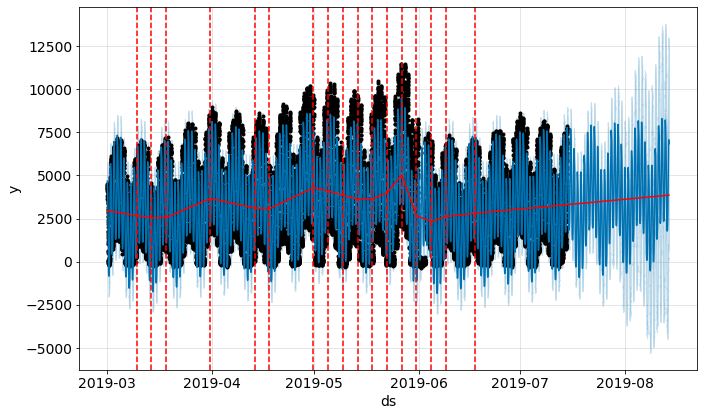

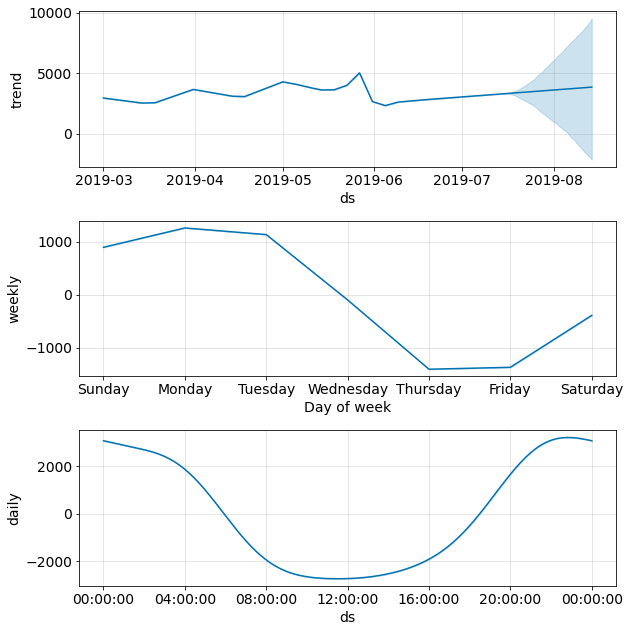

============= Forecast results for varB =============


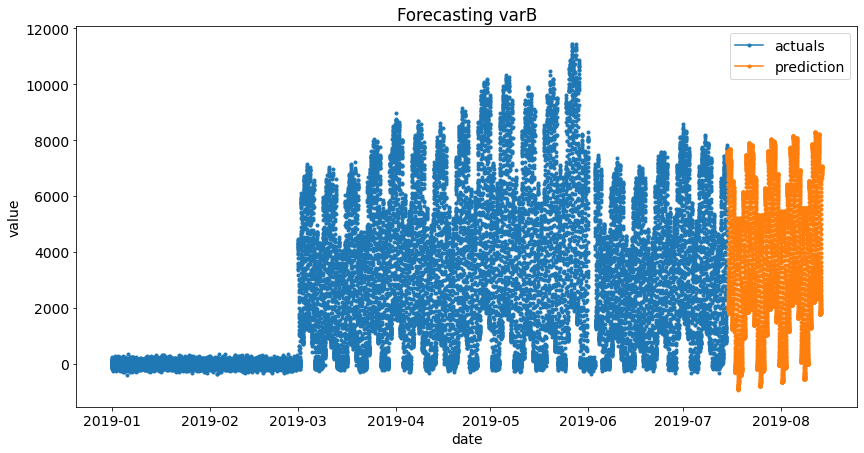

In [21]:
horizon_days = (final_datetime - dfB.index.max()).days
f = '10T'
horizon_period = horizon_days * 24 * 6 # days to 10 minute pediods
future = model_varB.make_future_dataframe(periods=horizon_period, freq=f)

# predict
fcst = model_varB.predict(future)

# plot results
plot_prophet(model_varB, fcst)

# save forecast results
varB_pred = fcst[fcst['ds'] > dfB.index.max()][['ds','yhat']]\
    .rename(columns={'yhat': 'varB'})\
    .set_index('ds')

# create datetime range
fcst_series = pd.date_range(start = df.index.max() + timedelta(minutes=5), end=final_datetime, freq='5T')

# create results dataframe
forecast_varB = pd.DataFrame(fcst_series, columns=['datetime']).set_index('datetime')
forecast_varB['varB'] = varB_pred

# plot forecast
print('============= Forecast results for varB =============')
plot_forecast(df[['varB']], forecast_varB, title='Forecasting varB', m='.')

##  Forecasting varC using an LSTM Network

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [73]:
dfC = df[['varC']].replace(0, np.nan).dropna()

I'm resampling to the hour since having data at a 5 minute step grain doesn't add value in terms of seasonality patters.

In [24]:
# resampling to daily for testing
dfC_hour = dfC.resample('H').sum()[:-1]

In [74]:
# creating train and test sets
data = dfC_hour.values

test_size = 30 * 24 # forecasting 30 days (in hours)
train, validate = data[0:len(data)-test_size], data[len(data)-test_size:len(data)]

In [26]:
# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

Creating the train datasets in 3D matrix format so the network can read

In [27]:
window = 60 * 24 # using a two month window (in hours)
x_train, y_train = [], []
for i in range(window,len(train)):
    x_train.append(scaled_data[i-window:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

print(x_train.shape, y_train.shape)

(2520, 1440, 1) (2520,)


The LSTM Network is composed by two layers of 20 and 50 neurons with Dropout layer to avoid overfitting.

In [28]:
# create model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1440, 20)          1760      
_________________________________________________________________
dropout (Dropout)            (None, 1440, 20)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                14200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 16,011
Trainable params: 16,011
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
history = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_split=0.1, shuffle=False)

Epoch 1/10
23/23 [==============================] - 45s 2s/step - loss: 0.1269 - val_loss: 0.0012
Epoch 2/10
23/23 [==============================] - 43s 2s/step - loss: 0.0263 - val_loss: 0.0048
Epoch 3/10
23/23 [==============================] - 43s 2s/step - loss: 0.0091 - val_loss: 7.6323e-04
Epoch 4/10
23/23 [==============================] - 43s 2s/step - loss: 0.0090 - val_loss: 2.8642e-04
Epoch 5/10
23/23 [==============================] - 42s 2s/step - loss: 0.0087 - val_loss: 4.6238e-04
Epoch 6/10
23/23 [==============================] - 42s 2s/step - loss: 0.0091 - val_loss: 7.8734e-04
Epoch 7/10
23/23 [==============================] - 43s 2s/step - loss: 0.0089 - val_loss: 7.8926e-04
Epoch 8/10
23/23 [==============================] - 42s 2s/step - loss: 0.0093 - val_loss: 8.4183e-04
Epoch 9/10
23/23 [==============================] - 44s 2s/step - loss: 0.0093 - val_loss: 8.5621e-04
Epoch 10/10
23/23 [==============================] - 46s 2s/step - loss: 0.0090 - val_loss

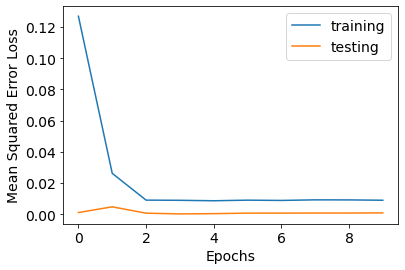

In [31]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')
plt.legend()
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epochs')
plt.show()

#### Simple step forecast on validation data

In this section I'm making simple step predictions using the trained model. The predictions are made using a window of true values. After each prediction, the window moves forward one step into the true values.

In [32]:
#predicting 30 days values, using the days from the defined window
inputs = data[len(data) - len(validate) - window:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [33]:
# create test dataset
x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i,0])
x_test = np.array(x_test)

# 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [34]:
# predict and transform back
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

In [35]:
# calculate error
mape = np.mean(np.abs((validate - pred) / validate)) * 100
mape

4.095231615451316

/Users/pvilar/VirtualEnvironments/adyen/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


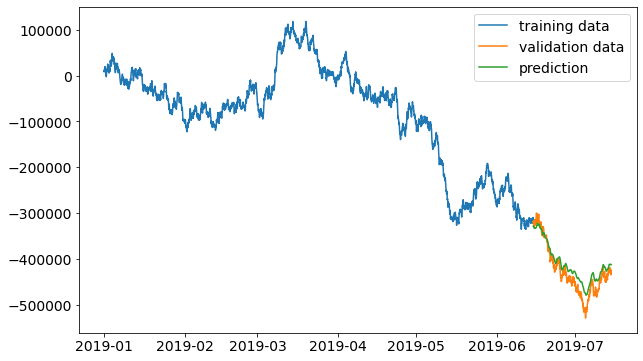

In [36]:
# plotting
train = dfC_hour[:len(train)]
validation = dfC_hour[len(train):]
validation['Predictions'] = pred

plt.figure(figsize=(10,6))
plt.plot(train['varC'], label='training data')
plt.plot(validation['varC'], label='validation data')
plt.plot(validation['Predictions'], label='prediction')
plt.legend()

#### Multi step forecast on validation data

Here, I'm making multi step predictions which is closer to the objective of the excercise. Using a window of 60 days I'm predicting the next 30 values. To do so, the window makes one prediction and then moves one step forward and insted of considering the following true data point, is considering the prediction made on the previous step. So the further we predict into the future, the more we are predicting on top of predictions, so the accuracy goes down. Increasing the window used to predict future values we would increase the accuracy, however it is more computationally costly.

In [76]:
# define the window as input for validating
inputs = data[len(train) - len(validate) - window:len(train) - len(validate)]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [38]:
# predict and move window one step forward so the following predicition will be made from an input that will partly contain predictions
dataset = inputs
forecast_out = 30 * 24 + 1 # 30 days into hours
step = dataset
predicted = []
for i in range(forecast_out):
    x_step = np.array(step)
    x_step = x_step.reshape(1, x_step.shape[0], 1) # reshape to  3D
    pred = model.predict(x_step) # predict one point
    predicted.append(pred[0][0]) # store prediction
    step = np.append(step, pred)[1:] # append prediction and define  new step
    
predicted = scaler.inverse_transform(np.array(predicted).reshape(1,-1))[0]

/Users/pvilar/VirtualEnvironments/adyen/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


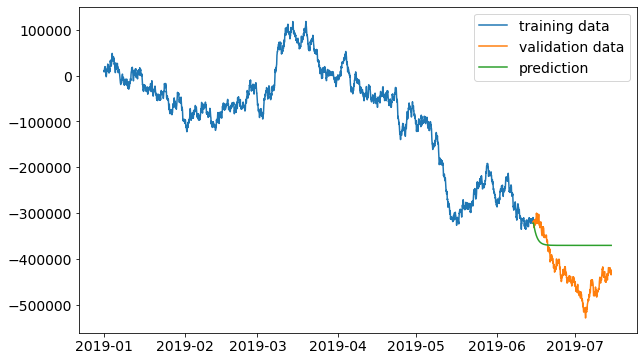

In [39]:
# plotting
train = dfC_hour[:len(train)]
validation = dfC_hour[len(train):]
validation['Predictions'] = predicted[:-1]

plt.figure(figsize=(10,6))
plt.plot(train['varC'], label='training data')
plt.plot(validation['varC'], label='validation data')
plt.plot(validation['Predictions'], label='prediction')
plt.legend()

In [40]:
# calculate error
mape = np.mean(np.abs((validate - predicted[1:]) / validate)) * 100
mape

16.170195199022988

#### Forecasting into the future

Here I'm performing a multi step prediction to predict the following 30 days into the future using a 60 days window.

In [41]:
inputs = data[len(data) - window:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

In [42]:
# predict and move window one step forward so the following predicition will be made from an input that will partly contain predictions
dataset = inputs
forecast_out = 30 * 24 + 1 # 30 days into hours
step = dataset
predicted = []
for i in range(forecast_out):
    x_step = np.array(step)
    x_step = x_step.reshape(1, x_step.shape[0], 1) # reshape to  3D
    pred = model.predict(x_step) # predict one point
    predicted.append(pred[0][0]) # store prediction
    step = np.append(step, pred)[1:] # append prediction and define  new step
    
predicted = scaler.inverse_transform(np.array(predicted).reshape(1,-1))[0]

In [43]:
from datetime import timedelta

# create dataframe of predictions
fcst_series = pd.date_range(df.index.max(), periods=len(predicted), freq='H')

forecast_varC = pd.DataFrame(fcst_series, columns=['datetime']).set_index('datetime')
forecast_varC['varC'] = predicted

# reshape into 5 minute step
forecast_varC = forecast_varC.resample('5T').ffill()[1:]
forecast_varC['varC'] = forecast_varC['varC']/12

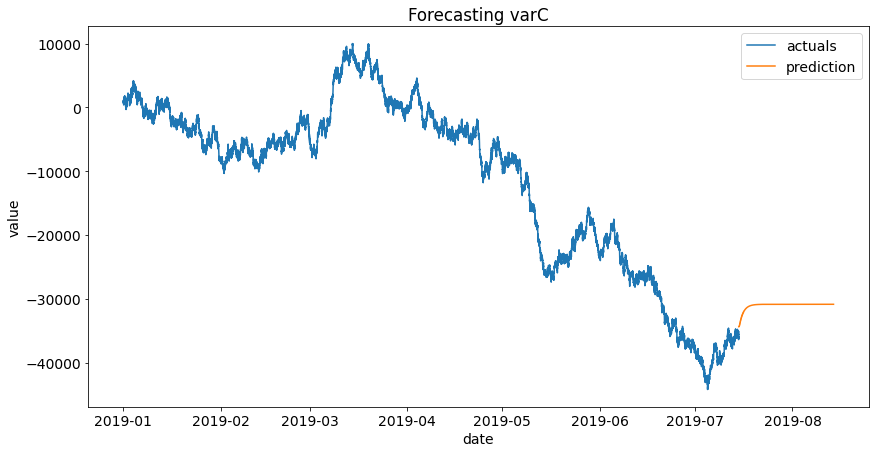

In [44]:
plot_forecast(df[['varC']], forecast_varC, title='Forecasting varC')

### Save predictions into a csv file

In [45]:
results = pd.concat([forecast_varA, forecast_varB, forecast_varC], axis=1)
results.to_csv('../results/results.csv', header=False)